# OBJETIVO

El objetivo del proyecto es distinguir tejados de poblaciones con vistas aereas ya sea por imágenes satélite o por drones. Para eso utilizaremos una red neural con una estructura en particular llamada U-NET, que se explicará mas adelante.

# Dataset y preprocesamiento

El data set usado es AIRS DATASET que corresponde a imagenes aéreas de Christchurch en Nueva Zelanda. Son 16,5 GB de imagenes para entrenamiento y validación y 1,5 GB de imágenes para test. Cada imagen tiene una dimensión de 10000 X 10000 píxeles. A su vez las imágenes se dividen entre las imagenes reales (de satelite) y las labels. Estás labels son imagenes en negro, dónde los píxeles que corresponden a un tejado son blancos (0 y 1). Al ser las imagenes tan grandes y tener poca capacidad de computación, las cortaremos en muchas imágenes pequeñas, de forma que puedan ser procesadas.

In [13]:
import os
import numpy as np
import cv2
import keras
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt
from sklearn.metrics import auc

Con el objetivo de no recortar imagenes aleatoriamente, de forma que apenas haya tejados, pues el datasets es demasiado grande para cortarlas y procesarlas todas, el problema se aborda de  la siguiente forma: Se identifica el contorno que corresponde a los tejados en las labels, se escala la imagen en función del tamaño del tejado y se recorta. Para que no se repitan imágenes, pues puede ser que los tejados estén muy juntos, se calcula el area que hay de solape entre las imágenes y si es mayor de 0.8 se descarta esa imagen directamente.

In [ ]:
from collections import namedtuple #Servirá para indicar las coordenadas del rectángulo dónde se inscribe el tejado
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax') 

In [ ]:
#Esta función se le pasan dos imágenes, devuelve si las imágenes se solapan más de 0.8 y qué imagen es mas pequeña. Pues descartamos
#la mas pequeña
def area(a, b):  
    area1=(a.xmax-a.xmin)*(a.ymax-a.ymin)
    area2=(b.xmax-b.xmin)*(b.ymax-b.ymin)
    minim=area1
    i='first'
    if area1>=area2:
        minim=area2
        i='sec'
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0) and (dx*dy/minim>0.8):#porcentaje de area compartida
        return 1,i
    else:
        return 0,0

In [ ]:
#Cargo el nombre de cada imagen que tiene una dimension de 10000x10000 píxeles
os.chdir('D:\\roof_images\\train\\image')
lista=os.listdir()
c=[]
for i in lista:
    if i.replace('.tif','')+'_vis.tif' in b:
        c.append(i.replace('.tif','')+'_vis.tif')
#Para cada imagen
for z in c:    
    label_1=[]
    im_1=[]    
    im=cv2.imread('D:\\trainval\\train\\label\\'+z)#Cargo la imagen label
    gray=cv2.cvtColor(im.copy(),cv2.COLOR_BGR2GRAY)#Pasa a gray
    gray = cv2.blur(gray, (11, 11))#difumina para mejorar la detección de bordes
    thresh = cv2.threshold(gray, 200, 250, cv2.THRESH_BINARY)[1]#Convierte a binario en blanco y negro
    en_todo=cv2.cvtColor(thresh.copy(),cv2.COLOR_GRAY2BGR)#Pasa a BGR otrvez
    contours,hierarchy=cv2.findContours(thresh,1,2)#Encuentra los contornos
    Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
    diccionario={}
    #En este blucle guarda las coordenadas de los rectángulos que inscriben al rectángulo. Añade espacio alrededor de los tejados
    #en función de su tamaño, y también comprueba que el recorte no se salga de las dimensiones de  la imagen
    for i,c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        if x-w>0 and y-h>0 and x+2*w<10000 and y+2*h<10000:
            ra = Rectangle(x-w,y-h,x+2*w, y+2*h)
        else:
            ra=0
        diccionario[i]=ra
    copia_dicc=diccionario.copy()
    #Ahora se comprueba el solape que hay entre las imagenes de los tejados y se descartan aquellas que tengan mayor solape 
    # de 0.8
    for i in range(len(contours)):
        for j in range(i+1,len(contours)):
            if (diccionario[i]!=0) & (diccionario[j]!=0):
                sup,which=area(diccionario[i],diccionario[j])
                if sup:
                    if which=='prim':
                        copia_dicc[i]=0
                    else:
                        copia_dicc[j]=0
    #Sirve para limpiar y quedarse solo con aquellos recortes que nos interesan
    for q in copia_dicc.keys():
        f=copia_dicc[q]
        if f!=0:
            label_1.append(im[f.ymin:f.ymax,f.xmin:f.xmax].copy())
    #         plt.figure()
    #         plt.imshow(im[f.ymin:f.ymax,f.xmin:f.xmax])
    
    im=cv2.imread('D:\\trainval\\train\\image\\'+z.replace('_vis',''))
    for q in copia_dicc.keys():
        f=copia_dicc[q]
        if f!=0:
            im_1.append(im[f.ymin:f.ymax,f.xmin:f.xmax].copy())
    #Guradamos los recortes tanto de las imagenes por satélite como de las labels con el mismo nombre para que sean fáciles
    #de leer después
    for num,l in enumerate(label_1):
        cv2.imwrite('D:\\roof_images\\segundo_entrenamiento\\label\\'+z+str(num)+'.tif',l)
    for num,i in enumerate(im_1):
        cv2.imwrite('D:\\roof_images\\segundo_entrenamiento\\image\\'+z+str(num)+'.tif',i)

Uno de los problemas que surgiría si a la red neuronal le pasasemos solo estas imágenes, esque siempre detectaría un tejado aunque la imagen no tuviese. Por ello seleccionamos imágenes puramente paisajísticas del data set y las recortamos. Elegimos las dimensiones de 500X500 píxeles. Saliéndonos por cada imagen 400 recortes

In [1]:
num=[24,25,33,34,49,50,51,1008,855,839,843,160,165,171,139,725,728,734,737,741,746,752]
sintej=[]
sintej_label=[]
#Leectura de las imagenes con paisaje mayoritariamente
for i in num:
    sintej.append(cv2.imread('christchurch_'+str(i)+'.tif'))
for i in num:
    sintej_label.append(cv2.imread('christchurch_'+str(i)+'_vis.tif'))
#Recorte y guardado de las imagenes en una carpeta
os.chdir('D:\\roof_images\\segundo_entrenamiento\\noroof_image')
for i,o in enumerate(sintej):
    for l in range(0,9500,500):
        for p in range(0,9500,500):
            cv2.imwrite(str(i)+str(l)+str(p)+'.tif',o[l:l+500,p:p+500])
os.chdir('D:\\roof_images\\segundo_entrenamiento\\noroof_label')
for i,o in enumerate(sintej_label):
    for l in range(0,9500,500):
        for p in range(0,9500,500):
            cv2.imwrite(str(i)+str(l)+str(p)+'.tif',o[l:l+500,p:p+500])
            os.chdir('D:\\not_roof')

IndentationError: unexpected indent (<ipython-input-1-b18d3e929e28>, line 5)

De esta manera se consigue un dataset rico y bastante grande. Se ha limitado el bucle por la gran cantidad de imágenes que producía (Se han conseguido de esta manera 50000 imágenes)

# Red Neuronal U-NET

El objetivo del proyecto es distinguir lo que es tejado de lo que no. Para ello se necesita entender qué es la segmentación de imágenes. La segmentación de imágenes consiste en el etiquetado de cada pixel en función de si pertenece a una categoría o a otra. La idea es que se etiquete cada pixel con un 1 o un 0 según sea tejado o no.

Para este tipo de clasificación se usa una red neuronal que fue desarrollada para la clasificacion de imagenes médicas por un departamento de una universidad alemana. Tiene la siguiente estructura:
<img src="unet_explanation.PNG">

Se puede ver porque la red recibe ese nombre. Consta basicamente de dos estructuras: El Encoder que son capas de neuronas de convolución y el Decoder que son capas de UP-sampling, donde se usa convolución traspuesta. El Encoder intuitivamente ayuda a determinar 'qué' es tejado y el Decoder 'dónde' está el tejado. La convolución traspuesta que se usa en el Decoder es el proceso contrario a la convolución, lo que se hace es aumentar la dimensión del tensor de salida. 
En cada caso del decoder se utilizan skip connections que en estructuras neuronales con mucha profundidad evitan el problema del vanishing gradient, también mejora la localización de los tejados. Estas skip connections consiste basicamente en concatenar las salidas de capas del encoder con las salidas de las capas del decoder a su mismo nivel.

https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0
Transposed convolution

In [ ]:
inputs=keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
#Inputs must be in floating points values dividing values by 255
# s=keras.layers.Lambda(lambda x: x/255)
#Contraction path
c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
c1=keras.layers.Dropout(0.1)(c1)
c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=keras.layers.MaxPooling2D((2,2))(c1)

c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=keras.layers.Dropout(0.1)(c2)
c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=keras.layers.MaxPooling2D((2,2))(c2)

c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=keras.layers.Dropout(0.2)(c3)
c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=keras.layers.MaxPooling2D((2,2))(c3)

c4=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=keras.layers.Dropout(0.2)(c4)
c4=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4=keras.layers.MaxPooling2D((2,2))(c4)

c5=keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=keras.layers.Dropout(0.3)(c5)
c5=keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
#Expansive path
u6=keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6=keras.layers.concatenate([u6,c4])
c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=keras.layers.Dropout(0.2)(c6)
c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7=keras.layers.concatenate([u7,c3])
c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=keras.layers.Dropout(0.2)(c7)
c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8=keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8=keras.layers.concatenate([u8,c2])
c8=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8=keras.layers.Dropout(0.1)(c8)
c8=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9=keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9=keras.layers.concatenate([u9,c1],axis=3)
c9=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9=keras.layers.Dropout(0.1)(c9)
c9=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

outputs=keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)
model=keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
#model.summary()
#kernel initializer defines the procedure to initialize the weights

In [56]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

Se ha entrenado el modelos con unas 45000 imagenes, tanto de tejados como de paisajes. Se ha hecho un shuffle para asegurar que no siguen un orden establecido y reforzar que aprenda mejor un tipo que otro.

In [ ]:
os.chdir('D:\\roof_images\\segundo_entrenamiento\\image')
lista_img=os.listdir()
os.chdir('D:\\roof_images\\segundo_entrenamiento\\label')
lista_label=os.listdir()
lista_img=set(lista_img)
lista_label=set(lista_label)
lista_total=lista_img.intersection(lista_label)
len(lista_total)

La red se ha entrenado varias veces con tandas de 1000 en 1000. Un problema que surgió es que al hacer el resize de las labels, los píxeles por el métdo de interpolación cambiaban y dejaban de ser binarios. Para solucionar eso se utilizó el INTER_NEAREST.

In [ ]:
X_brute=[]
os.chdir('D:\\roof_images\\segundo_entrenamiento\\image')
for i in lista_total[u:u+1000]:
    X_brute.append(cv2.imread(i))
os.chdir('D:\\roof_images\\segundo_entrenamiento\\label')
y_brute=[]
for j in lista_total[u:u+1000]:
    y_brute.append(cv2.imread(j))
X_brute, y_brute=shuffle(X_brute,y_brute)
X_resize=[]
y_resize=[]
for i,j in zip(X_brute,y_brute):
    X_resize.append(cv2.resize(i,(128,128), interpolation = cv2.INTER_AREA))
    y_resize.append(cv2.resize(j,(128,128), interpolation = cv2.INTER_NEAREST ))#Se usa esta interpolación para que solo haya ceros y 
    #unos
y_norm=[]
for i in y_resize:
    y_norm.append(i[:,:,0]/255)
X=np.array(X_resize)/255
y=np.array(y_norm.copy())
X_train=X
y_train=y
checkpointer=keras.callbacks.ModelCheckpoint('model_for_roofs_sec.h5',verbose=1,save_best_only=True)
callbacks=[keras.callbacks.EarlyStopping(patience=4,monitor='val_loss'),keras.callbacks.TensorBoard(log_dir='logsi')]
results=model.fit(X_train,y_train,epochs=15,verbose=1,validation_split=0.2,callbacks=callbacks)#Para entrenar el model

Se añade un Early Stop con el objetivo de que no siga entrenando si el val_loss no mejora, un checkpoint por si llegase a haber algún fallo y una callback para TensorBoard que nos graficará automaticamente el accuracy y el function loss por epoch.
El accuracy es una buena métrica en este caso porque gran parte de las imágenes están ocupadas por tejados, si no fuese así, no sería una métrica muy efectiva. Pues si no acertase los tejados en imágenes donde apenas hay, esto no se vería reflejado en el accuracy.

<img src="trabajo.PNG">

Tras varios entrenamientos los valores oscilan en ese intervalo.

# Resultados y Análisis del error

tensorboard --logdir=logsi/ --host localhost --port 8088

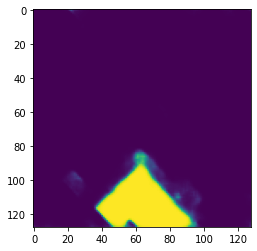

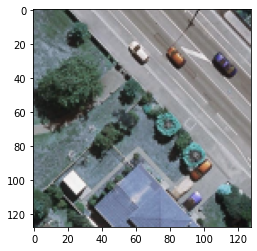

In [21]:
r=80
os.chdir('D:\\trainval\\test')
lista=os.listdir()
ims=[]
for i in lista[:500]:
    ims.append(cv2.imread(i))
X_resize=[]
for i in ims:
    X_resize.append(cv2.resize(i,(128,128), interpolation = cv2.INTER_AREA))
X=np.array(X_resize)/255
pred=model.predict(X)
plt.figure()
plt.imshow(pred[r])
plt.figure()
plt.imshow(X[r])
os.chdir('C:\\Users\\anton\\Documents\\Bootcamp\\Proyecto')
cv2.imwrite('imagen8.png',X[r])
plt.show()

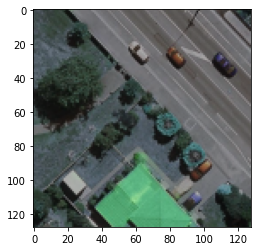

In [22]:
img_gray = cv2.cvtColor(pred[r], cv2.COLOR_GRAY2BGR)
img_gray[:,:,2]=0
img_gray[:,:,0]=0
dst = cv2.addWeighted(img_gray.astype(np.double), 0.3, X[r].astype(np.double), 0.7,0)
plt.imshow((dst * 255).astype(np.uint8))
plt.show()

In [9]:
os.chdir('D:\\roof_images\\segundo_entrenamiento\\image')
lista_total=os.listdir()
random.shuffle(lista_total)
u=0

In [10]:
import cv2
X_brute=[]
os.chdir('D:\\roof_images\\segundo_entrenamiento\\image')
for i in lista_total[u:u+100]:
    X_brute.append(cv2.imread(i))
os.chdir('D:\\roof_images\\segundo_entrenamiento\\label')
y_brute=[]
for j in lista_total[u:u+100]:
    y_brute.append(cv2.imread(j))
X_brute, y_brute=shuffle(X_brute,y_brute)
X_resize=[]
y_resize=[]
for i,j in zip(X_brute,y_brute):
    X_resize.append(cv2.resize(i,(128,128), interpolation = cv2.INTER_AREA))
    y_resize.append(cv2.resize(j,(128,128), interpolation = cv2.INTER_NEAREST ))
y_norm=[]
for i in y_resize:
    y_norm.append(i[:,:,0]/255)
X=np.array(X_resize)/255
y=np.array(y_norm.copy())
X_test=X
y_test=y

In [11]:
os.chdir('C:\\Users\\anton\\Documents\\Bootcamp\\Proyecto')
model=keras.models.load_model('modelo_UNET_muy_final.h5')
y_pred_keras=model.predict(X_test)
y_pred_keras_r =model.predict(X_test).ravel()

y_test_r=y_test.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_r, y_pred_keras_r)

In [14]:
auc_keras = auc(fpr_keras, tpr_keras)

In [16]:
auc_keras

0.9918465011143125

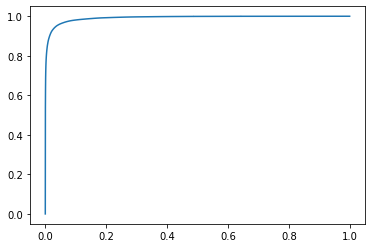

In [17]:
plt.plot(fpr_keras,tpr_keras)
plt.show()

La curva ROC representa la razon \begin{equation*}\frac{FP}{FP+VN}\end{equation*} frente a \begin{equation*}\frac{VP}{VP+FN}\end{equation*}para distintos cortes en la probabilidad de que un elemento pertenezca a una clase o a otra.

Usar el accuracy como métrica en la segmentación de imágenes puede ser engañoso si en las imágenes las clases están desbalanceadas. En nuestro caso si apenas hubiese tejado en las fotografías. En nuestro caso si es una métrica representativa porque la mayoría de nuestras imágenes tienen un porcentaje alto de tejados ocupando la foto. Una métrica que se suele usar para la segmentación de imágenes es el dice score que es  \begin{equation*}\frac{2*TP}{2*TP+FP+FN}\end{equation*}

In [18]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
dice_coef(y_test_r.astype(np.double),y_pred_keras_r.astype(np.double))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9339601879264908>

Lineas de mejora: 
El principal problema de el proyecto ha sido el procesamiento y el entrenamiento. Se ha hecho de forma local y por batches. Se ha elegido una resolución de 128 para el escalamiento de las imágenes, sin embargo se podría hacer elgido de 256, ya que al hacer el resize de imágenes grandes a una dimensión mas pequeña se pierde información. A pesar de haber usado 50000 imágenes se ha limitado el tamaño del dataset por el tiempo de procesamiento que hubiese tomado. Se puede hacer un gridsearch de ciertos parámetros para la optimización de la red, a pesar de que tiene una estructura fija. 

Otra linea de mejora es que a aprendido con casas y barrios típicos de Nueva Zelanda, por lo que no es extrapolable a ciudades de otros paises que tengan casas muy diferente

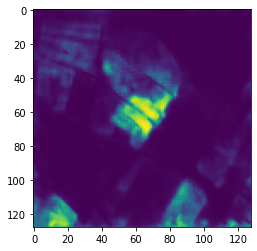

In [51]:
pruebas=['bohadilla.PNG','chamartin.PNG','getafe.PNG']
os.chdir('C:\\Users\\anton\\Documents\\Bootcamp\\Proyecto')
ims=[]
for i in pruebas:
    ims.append(cv2.imread(i))
for i in range(len(ims)):
    ims[i] = cv2.cvtColor(ims[i] , cv2.COLOR_BGR2RGB)

X_resize=[]
for i in ims:
    X_resize.append(cv2.resize(i,(128,128), interpolation = cv2.INTER_AREA))
X=np.array(X_resize)/255
pred=model.predict(X)
plt.imshow(pred[2])

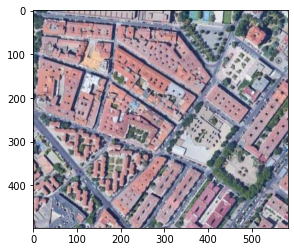

In [54]:
plt.imshow(ims[2])

The data set used for this project was provided by
  title:Aerial imagery for roof segmentation: A large-scale dataset towards automatic mapping of buildings
  author:Chen, Qi and Wang, Lei and Wu, Yifan and Wu, Guangming and Guo, Zhiling and Waslander, Steven L
  journal:ISPRS Journal of Photogrammetry and Remote Sensing
  